In [1]:
from pyspark.sql import SparkSession
from pymongo import MongoClient
import urllib.parse
import pyspark.sql.functions as sqlf
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinHashLSH, NGram, Tokenizer, CountVectorizer, BucketedRandomProjectionLSH
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, ArrayType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import monotonically_increasing_id
import numpy as np
import math

from DisjointSet import DisjointSet
import sys
sys.setrecursionlimit(3000000)

normalized_file = 'normalizedTweetsWithoutLinks_2019_test.txt'
results_file = 'results/TweetsAlike_2019_word2vec.txt'
beautify_results_file = 'results/niceResults_2019_word2vec.txt'

credPath = 'credentialsMongo.txt'
credFile = open(credPath, 'r')
loginMA = urllib.parse.quote_plus(credFile.readline().strip())
passwordMA = urllib.parse.quote_plus(credFile.readline()).strip()

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("twitter") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.3.0') \
    .config("spark.mongodb.input.uri", "mongodb+srv://" +
            loginMA + ":" +
            passwordMA +
            "@doublesearchintwitter-m3qge.mongodb.net/twitter_march2019.tweets") \
    .config("spark.mongodb.output.uri", "mongodb+srv://" +
            loginMA + ":" +
            passwordMA +
            "@doublesearchintwitter-m3qge.mongodb.net/") \
    .getOrCreate()


from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from pyspark import SparkContext

import os
import sys

os.environ["PYSPARK_PYTHON"] = "/Users/martikvm/anaconda3/envs/py35/bin/python"

/Users/martikvm/anaconda3/envs/py35/lib/python3.5/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
df1 = spark.read.text(normalized_file).withColumn("id", monotonically_increasing_id())

In [3]:
model = KeyedVectors.load_word2vec_format('/Users/martikvm/PycharmProjects/DoubleSearch/twitter/model.bin', binary=True)
#model = KeyedVectors.load_word2vec_format('/Users/martikvm/PycharmProjects/DoubleSearch/twitter/model1.model', binary=False)

In [ ]:
model.vocab

In [ ]:
df1.show()

In [4]:
tokenizer = Tokenizer(inputCol="value", outputCol="words")
pipeline = Pipeline(stages=[tokenizer])
model1 = pipeline.fit(df1)
df2 = model1.transform(df1)
df2.show()

+--------------------+---+--------------------+
|               value| id|               words|
+--------------------+---+--------------------+
|"- Ох, Анечка, ес...|  0|["-, ох,, анечка,...|
|твой путь (Владим...|  1|[твой, путь, (вла...|
|[user] Я уж руки ...|  2|[[user], я, уж, р...|
|[user] [user] [us...|  3|[[user], [user], ...|
|[user] У меня нет...|  4|[[user], у, меня,...|
|  [user] Так что, да|  5|[[user], так, что...|
|[user] [user] [us...|  6|[[user], [user], ...|
|Ещё одна Юля, тол...|  7|[ещё, одна, юля,,...|
|[user] Я перемаза...|  8|[[user], я, перем...|
|[user] Это что ща...|  9|[[user], это, что...|
|чувак хочет кожан...| 10|[чувак, хочет, ко...|
|                ОКЕЙ| 11|              [окей]|
|сука знаете что к...| 12|[сука, знаете, чт...|
|Украинцев ждет но...| 13|[украинцев, ждет,...|
|    #Здоровье [link]| 14| [#здоровье, [link]]|
|побейте меня если...| 15|[побейте, меня, е...|
|надеюсь все прави...| 16|[надеюсь, все, пр...|
|За 2 недели до сд...| 17|[за, 2, недели

In [5]:
def getVectors(v):
    sum_vectors = np.zeros(300)
    count = len(v)
    for i in v:
        try: 
            sum_vectors += model.get_vector(i + "_NOUN")
        except:
            try:
                sum_vectors += model.get_vector(i + "_VERB")
            except:
                try:
                    sum_vectors += model.get_vector(i + "_PROPN")
                except:
                    try:
                        sum_vectors += model.get_vector(i + "_INTJ")
                    except:
                        try:
                            sum_vectors += model.get_vector(i + "_ADV")
                        except:
                            try:
                                sum_vectors += model.get_vector(i + "_ADJ")
                            except:
                                try:
                                    sum_vectors += model.get_vector(i + "_ADP")
                                except:
                                    try:
                                        sum_vectors += model.get_vector(i + "_AUX")
                                    except:
                                        try:
                                            sum_vectors += model.get_vector(i + "_CCONJ")
                                        except:
                                            try:
                                                sum_vectors += model.get_vector(i + "_DET")
                                            except:
                                                try:
                                                    sum_vectors += model.get_vector(i + "_NUM")
                                                except:
                                                    try:
                                                        sum_vectors += model.get_vector(i + "_PART")
                                                    except:
                                                        try:
                                                            sum_vectors += model.get_vector(i + "_PRON")
                                                        except:
                                                            try:
                                                                sum_vectors += model.get_vector(i + "_SCONJ")
                                                            except:
                                                                try:
                                                                    sum_vectors += model.get_vector(i + "_PUNCT")
                                                                except:
                                                                    try:
                                                                        sum_vectors += model.get_vector(i + "_SYM")
                                                                    except:
                                                                        try:
                                                                            sum_vectors += model.get_vector(i + "_X")
                                                                        except:
                                                                            pass
    vector = Vectors.dense(sum_vectors / count)
    if vector != Vectors.dense(model.get_vector('конь_NOUN') - model.get_vector('конь_NOUN')):
        return vector
    return

       
getVectors_udf = udf(getVectors, VectorUDT())
df3 = df2.select("id", "value", "words", getVectors_udf("words").alias("features"))
df3.show()

+---+--------------------+--------------------+--------------------+
| id|               value|               words|            features|
+---+--------------------+--------------------+--------------------+
|  0|"- Ох, Анечка, ес...|["-, ох,, анечка,...|[-0.0100879698681...|
|  1|твой путь (Владим...|[твой, путь, (вла...|[0.01080389427287...|
|  2|[user] Я уж руки ...|[[user], я, уж, р...|[0.03005377762019...|
|  3|[user] [user] [us...|[[user], [user], ...|[-0.0331375510742...|
|  4|[user] У меня нет...|[[user], у, меня,...|[0.03763646715217...|
|  5|  [user] Так что, да|[[user], так, что...|[-0.1999965831637...|
|  6|[user] [user] [us...|[[user], [user], ...|[0.02100751442568...|
|  7|Ещё одна Юля, тол...|[ещё, одна, юля,,...|[-0.0146749243140...|
|  8|[user] Я перемаза...|[[user], я, перем...|[-8.0795213580131...|
|  9|[user] Это что ща...|[[user], это, что...|[-0.0926305919885...|
| 10|чувак хочет кожан...|[чувак, хочет, ко...|[-0.0597356206604...|
| 11|                ОКЕЙ|        

In [6]:
df3_not_Null = df3.na.drop()
df3.count()
df3_not_Null.count()

204010

In [17]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
mh = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=0.0001,
                                  numHashTables=128)
model2 = mh.fit(df3_not_Null)
transformed_df2 = model2.transform(df3_not_Null)
transformed_df2.cache()
transformed_df2.show()

+---+--------------------+--------------------+--------------------+--------------------+
| id|               value|               words|            features|              hashes|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|"- Ох, Анечка, ес...|["-, ох,, анечка,...|[-0.0100879698681...|[[1139.0], [-112....|
|  1|твой путь (Владим...|[твой, путь, (вла...|[0.01080389427287...|[[-30.0], [158.0]...|
|  2|[user] Я уж руки ...|[[user], я, уж, р...|[0.03005377762019...|[[72.0], [-1130.0...|
|  3|[user] [user] [us...|[[user], [user], ...|[-0.0331375510742...|[[72.0], [-157.0]...|
|  4|[user] У меня нет...|[[user], у, меня,...|[0.03763646715217...|[[-245.0], [-583....|
|  5|  [user] Так что, да|[[user], так, что...|[-0.1999965831637...|[[-114.0], [-201....|
|  6|[user] [user] [us...|[[user], [user], ...|[0.02100751442568...|[[78.0], [-605.0]...|
|  7|Ещё одна Юля, тол...|[ещё, одна, юля,,...|[-0.0146749243140...|[[963.0], [-1300....|
|  8|[user

In [8]:
def colour_tweets(rows_with_ids, edges):
    cnt = 1
    for row in rows_with_ids:
        # print(row)
        cnt += 1
        
        ids = row["ids"]
        for x in ids[1:]:
            edges.union(ids[0], x)

In [22]:

def getHashColumnsAll(df0):
    result = []
    a = 1000
    for y in range(len(df0) // 4):
    #for y in range(1, 2):   
        sum_of_hashes =\
            (int(df0[4 * y][0]) + a) * math.pow((2 * a + 1), 3) +\
            (int(df0[4 * y + 1][0]) + a) * math.pow((2 * a + 1), 2) +\
            (int(df0[4 * y + 2][0]) + a) * (2 * a + 1) +\
            int(df0[4 * y + 3][0] + a)
        result.append(int(sum_of_hashes))
    return result

gethashsumsall_udf = udf(getHashColumnsAll, ArrayType(IntegerType()))

df4_all_sums = transformed_df2.select(
    "value",
    "id",
    gethashsumsall_udf("hashes").alias("hashes_sum")
)

df4_all_sums.cache()
df4_all_sums.show()

+--------------------+---+--------------------+
|               value| id|          hashes_sum|
+--------------------+---+--------------------+
|"- Ох, Анечка, ес...|  0|[23751611, -14965...|
|твой путь (Владим...|  1|[-1899228058, 168...|
|[user] Я уж руки ...|  2|[-1582300116, 217...|
|[user] [user] [us...|  3|[-1981635403, -10...|
|[user] У меня нет...|  4|[-872658983, -158...|
|  [user] Так что, да|  5|[-2035100643, 108...|
|[user] [user] [us...|  6|[1346172505, -170...|
|Ещё одна Юля, тол...|  7|[-1801389114, -16...|
|[user] Я перемаза...|  8|[-97307669, -2117...|
|[user] Это что ща...|  9|[-345547899, 4627...|
|чувак хочет кожан...| 10|[-362199858, -971...|
|                ОКЕЙ| 11|[1139921483, -668...|
|сука знаете что к...| 12|[127745542, 16120...|
|Украинцев ждет но...| 13|[320303415, -1615...|
|побейте меня если...| 15|[-1889643217, -36...|
|надеюсь все прави...| 16|[-669461349, -783...|
|За 2 недели до сд...| 17|[2089111251, 2905...|
|Ой знакомое что-т...| 18|[235879121, -1

In [23]:
max_tweet_id = df1.agg({"id": "max"}).collect()[0][0]
edges = DisjointSet(max_tweet_id + 1)

with open(results_file, 'w') as outf:     
    for k in range(128 // 4):
    #for k in range(0, 1):
        print("k = " + str(k))
        
        df4_group = df4_all_sums.groupBy(df4_all_sums.hashes_sum[k])\
            .agg(
                sqlf.count('id').alias("num_tweets"),
                sqlf.collect_list("value").alias("tweets_texts"),
                sqlf.collect_list("id").alias("ids")
            )\
            .filter(col("num_tweets") > 1)
        
        df4_group.cache()
        print("df4 cached")
                        
        colour_tweets(df4_group.select("ids").collect(), edges)
        print("We coloured some tweets! Way to go!")
        print()


k = 0
df4 cached
We coloured some tweets! Way to go!

k = 1
df4 cached
We coloured some tweets! Way to go!

k = 2
df4 cached
We coloured some tweets! Way to go!

k = 3
df4 cached
We coloured some tweets! Way to go!

k = 4
df4 cached
We coloured some tweets! Way to go!

k = 5
df4 cached
We coloured some tweets! Way to go!

k = 6
df4 cached
We coloured some tweets! Way to go!

k = 7
df4 cached
We coloured some tweets! Way to go!

k = 8
df4 cached
We coloured some tweets! Way to go!

k = 9
df4 cached
We coloured some tweets! Way to go!

k = 10
df4 cached
We coloured some tweets! Way to go!

k = 11
df4 cached
We coloured some tweets! Way to go!

k = 12
df4 cached
We coloured some tweets! Way to go!

k = 13
df4 cached
We coloured some tweets! Way to go!

k = 14
df4 cached
We coloured some tweets! Way to go!

k = 15
df4 cached
We coloured some tweets! Way to go!

k = 16
df4 cached
We coloured some tweets! Way to go!

k = 17
df4 cached
We coloured some tweets! Way to go!

k = 18
df4 cached
We

In [ ]:
import pickle
with open("edges_word2vec.pickle", 'wb') as f:
    pickle.dump(edges, f)
with open("edges_word2vec.vertices.pickle", 'wb') as f:
    pickle.dump(edges.vertices, f)

In [24]:

def add_color(ind):
    return edges.find(ind) 

add_color_udf = udf(add_color, IntegerType())

df11 = df1\
    .select(
        df1.value.alias("tweet"),
        add_color_udf(df1.id).alias("color")
    )\
    .groupBy("color")\
    .agg(sqlf.collect_list("tweet").alias("tweets"))
df11.show()

+-----+--------------------+
|color|              tweets|
+-----+--------------------+
|  148|[Полицейский с Ру...|
|  463|[Не спрашивайте ф...|
|  471|[также исследован...|
|  833|[обойду, если теб...|
| 1088|[[user] я пришла ...|
| 1238|[[user] В 8-9 я з...|
| 1342|[ну да, либо молч...|
| 1580|[[user] На неё бы...|
| 1591|[учиться лишь бы ...|
| 1645|[Явно нужно сдела...|
| 1829|[хочу зелёные вол...|
| 1959|[[user] И что? Ко...|
| 2122|[[user] умоляю я ...|
| 2142|[[user] ППХАХАХЧХ...|
| 2366|[какой твой любим...|
| 2659|[А лучше просто К...|
| 2866|[Завтра бы домой ...|
| 3175|[[user] Взвешиваю...|
| 3749|        [Цена129грн]|
| 3918|[[user] [user] Вы...|
+-----+--------------------+
only showing top 20 rows



In [25]:
with open("results/similar tweets with word2vec.txt", "w") as outf:
    for row in df11.collect():
        tweetsCount = len(row.tweets)
        if tweetsCount <= 1:
            continue
        outf.write("============ color: " + str(row.color) + ", tweets: " + str(tweetsCount) + "===========\n")
        for tweet in row.tweets:
            outf.write(tweet)
            outf.write("\n")
        outf.write("\n\n")
        

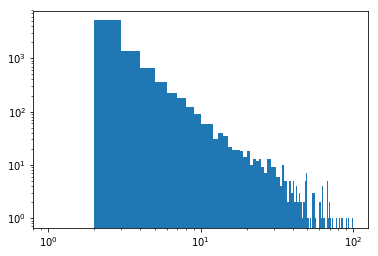

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections

dictOfDoubles = {}
with open("results/similar tweets with word2vec.txt", "r") as doublesFile:
    for line in doublesFile:
        lineStripped = line.strip()
        if lineStripped.startswith("============ color: "):
            endpoint1 = lineStripped.find(", tweets:")
            #print(colour)
            colour = int(lineStripped[20:endpoint1])
            lineHalf = lineStripped[20:]
            startpoint2 = endpoint1 + 9
            endpoint2 = 20 + lineHalf.find("===========")
            tweets = int(lineStripped[startpoint2:endpoint2])
            #print(tweets)
            dictOfDoubles[colour] = tweets

keys = list(dictOfDoubles.keys())
vals = list(dictOfDoubles.values())
plt.hist(vals, bins=list(range(100)))
plt.yscale('log')
plt.xscale('log')
plt.show()

